# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled_layer = bilinear_upsample(small_ip_layer)
    
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    concatenated_layer = keras.layers.concatenate([upsampled_layer, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    output_layer1 = separable_conv2d_batchnorm(concatenated_layer, filters)
    output_layer2 = separable_conv2d_batchnorm(output_layer1, filters)
    
    return output_layer2

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    encoded_layer1 = encoder_block(inputs,         filters=16, strides=2)
    encoded_layer2 = encoder_block(encoded_layer1, filters=32, strides=2)
    encoded_layer3 = encoder_block(encoded_layer2, filters=64, strides=2)
    print(' | -> encoded_layer1:', encoded_layer1)
    print('  | -> encoded_layer2:', encoded_layer2)
    print('   | -> encoded_layer3:', encoded_layer3)

    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    layer_1x1 = conv2d_batchnorm(encoded_layer3, 128, kernel_size=1, strides=1)
    print('    | -> layer_1x1:', layer_1x1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    decoded_layer1 = decoder_block(layer_1x1,      encoded_layer2, filters=64)
    decoded_layer2 = decoder_block(decoded_layer1, encoded_layer1, filters=32)
    decoded_layer3 = decoder_block(decoded_layer2, inputs,         filters=16)
    print('   | -> decoded_layer1:', decoded_layer1)
    print('  | -> decoded_layer2:', decoded_layer2)
    print(' | -> decoded_layer3:', decoded_layer3)
    
    x = decoded_layer3
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

print('inputs:', inputs) # For debugging

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)
print(' => output_layer:', output_layer) # For debugging

inputs: Tensor("input_1:0", shape=(?, 160, 160, 3), dtype=float32)
 | -> encoded_layer1: Tensor("batch_normalization/batchnorm/add_1:0", shape=(?, 80, 80, 16), dtype=float32)
  | -> encoded_layer2: Tensor("batch_normalization_2/batchnorm/add_1:0", shape=(?, 40, 40, 32), dtype=float32)
   | -> encoded_layer3: Tensor("batch_normalization_3/batchnorm/add_1:0", shape=(?, 20, 20, 64), dtype=float32)
    | -> layer_1x1: Tensor("batch_normalization_4/batchnorm/add_1:0", shape=(?, 20, 20, 128), dtype=float32)
   | -> decoded_layer1: Tensor("batch_normalization_6/batchnorm/add_1:0", shape=(?, 40, 40, 64), dtype=float32)
  | -> decoded_layer2: Tensor("batch_normalization_8/batchnorm/add_1:0", shape=(?, 80, 80, 32), dtype=float32)
 | -> decoded_layer3: Tensor("batch_normalization_10/batchnorm/add_1:0", shape=(?, 160, 160, 16), dtype=float32)
 => output_layer: Tensor("conv2d_2/truediv:0", shape=(?, 160, 160, 3), dtype=float32)


### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
learning_rate = 0.002
batch_size = 60
num_epochs = 100
steps_per_epoch = 40
validation_steps = 50
workers = 4

In [9]:
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)
model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

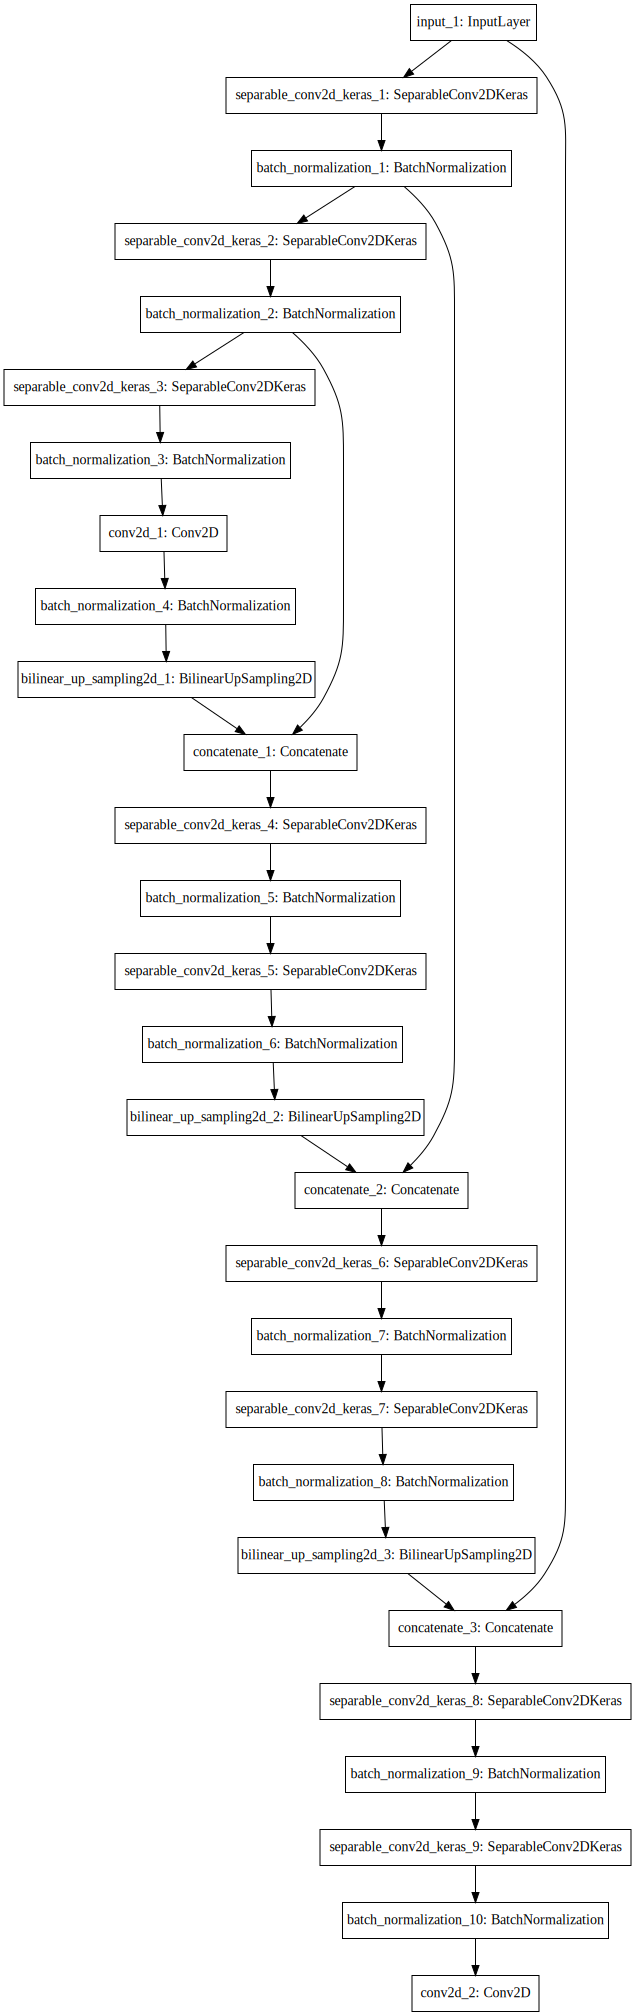

In [10]:
# Visualize model
## Needs installing graphiz and pydot_ng from pip
## Windows:
##   $ scoop install graphviz
## Else:
##   $ conda install graphviz
## And:
##   $ pip install pydot_ng

svg = None
try:
    from tensorflow.contrib.keras.python.keras.utils.vis_utils import model_to_dot
    from IPython.display import SVG
    svg = SVG(model_to_dot(model).create(prog='dot', format='svg'))
except (ImportError, Exception) as e:
    print(e, file=sys.stderr)
    print('It could not snow visualize model. This is NOT error. ', file=sys.stderr)
except:
    raise
svg

Epoch 1/100
39/40 [============================>.] - ETA: 0s - loss: 1.0031

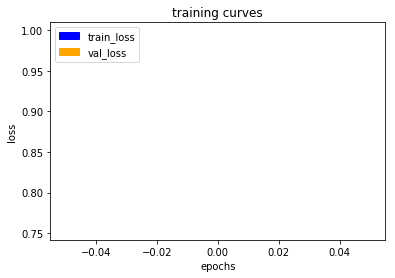

40/40 [==============================] - 48s - loss: 0.9976 - val_loss: 0.7539
Epoch 2/100
39/40 [============================>.] - ETA: 0s - loss: 0.5808

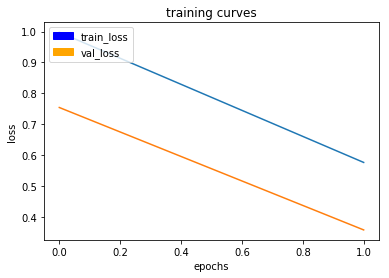

40/40 [==============================] - 42s - loss: 0.5759 - val_loss: 0.3573
Epoch 3/100
39/40 [============================>.] - ETA: 0s - loss: 0.2563

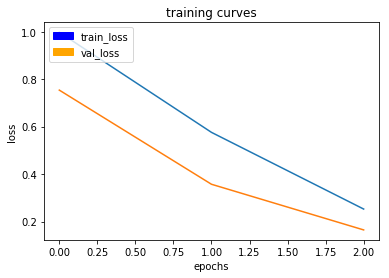

40/40 [==============================] - 42s - loss: 0.2542 - val_loss: 0.1650
Epoch 4/100
39/40 [============================>.] - ETA: 0s - loss: 0.1257

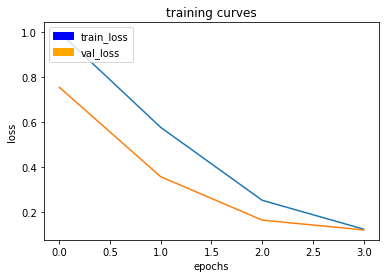

40/40 [==============================] - 42s - loss: 0.1250 - val_loss: 0.1216
Epoch 5/100
39/40 [============================>.] - ETA: 0s - loss: 0.0818

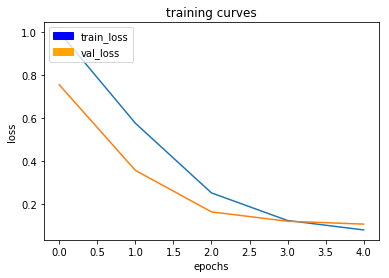

40/40 [==============================] - 41s - loss: 0.0815 - val_loss: 0.1082
Epoch 6/100
39/40 [============================>.] - ETA: 0s - loss: 0.0636

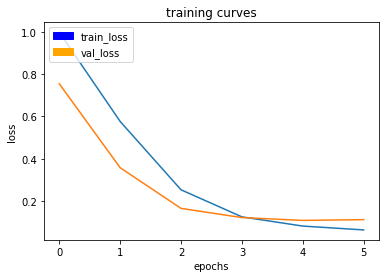

40/40 [==============================] - 42s - loss: 0.0633 - val_loss: 0.1119
Epoch 7/100
39/40 [============================>.] - ETA: 0s - loss: 0.0513

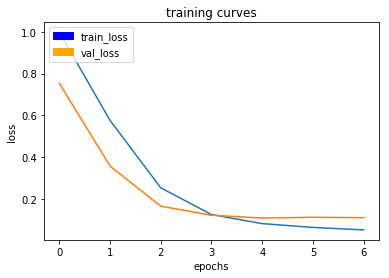

40/40 [==============================] - 41s - loss: 0.0511 - val_loss: 0.1100
Epoch 8/100
39/40 [============================>.] - ETA: 0s - loss: 0.0489

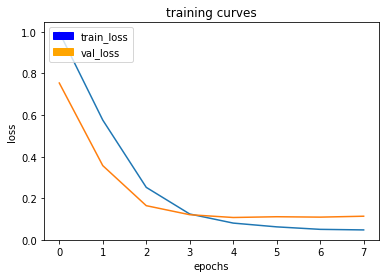

40/40 [==============================] - 42s - loss: 0.0486 - val_loss: 0.1144
Epoch 9/100
39/40 [============================>.] - ETA: 0s - loss: 0.0428

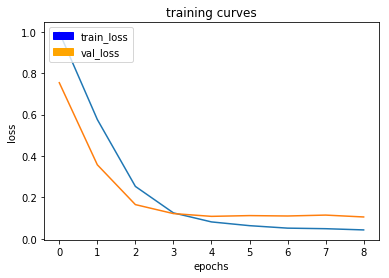

40/40 [==============================] - 41s - loss: 0.0426 - val_loss: 0.1053
Epoch 10/100
39/40 [============================>.] - ETA: 0s - loss: 0.0403

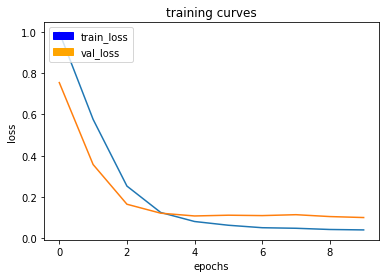

40/40 [==============================] - 42s - loss: 0.0407 - val_loss: 0.1006
Epoch 11/100
39/40 [============================>.] - ETA: 0s - loss: 0.0353

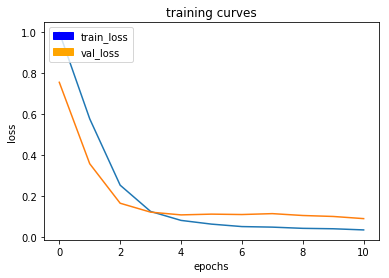

40/40 [==============================] - 41s - loss: 0.0354 - val_loss: 0.0901
Epoch 12/100
39/40 [============================>.] - ETA: 0s - loss: 0.0375

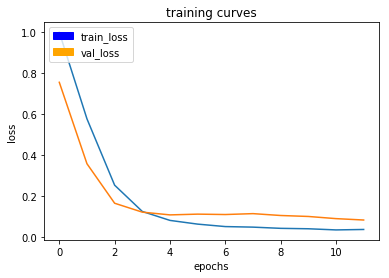

40/40 [==============================] - 42s - loss: 0.0373 - val_loss: 0.0833
Epoch 13/100
39/40 [============================>.] - ETA: 0s - loss: 0.0330

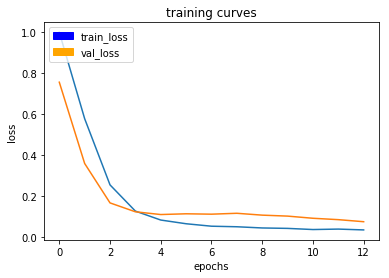

40/40 [==============================] - 41s - loss: 0.0333 - val_loss: 0.0732
Epoch 14/100
39/40 [============================>.] - ETA: 0s - loss: 0.0331

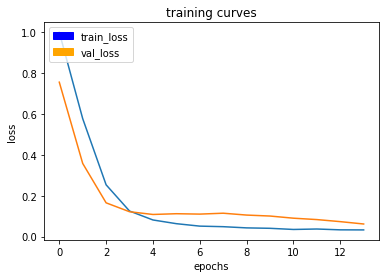

40/40 [==============================] - 42s - loss: 0.0328 - val_loss: 0.0618
Epoch 15/100
39/40 [============================>.] - ETA: 0s - loss: 0.0287

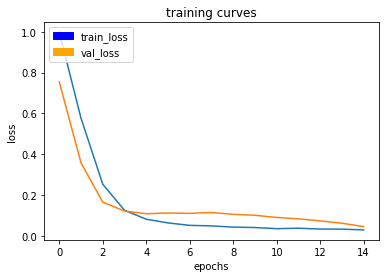

40/40 [==============================] - 42s - loss: 0.0290 - val_loss: 0.0454
Epoch 16/100
39/40 [============================>.] - ETA: 0s - loss: 0.0285

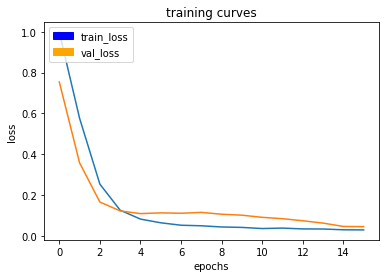

40/40 [==============================] - 41s - loss: 0.0282 - val_loss: 0.0445
Epoch 17/100
39/40 [============================>.] - ETA: 0s - loss: 0.0299

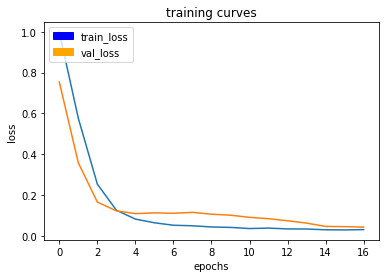

40/40 [==============================] - 42s - loss: 0.0300 - val_loss: 0.0422
Epoch 18/100
39/40 [============================>.] - ETA: 0s - loss: 0.0279

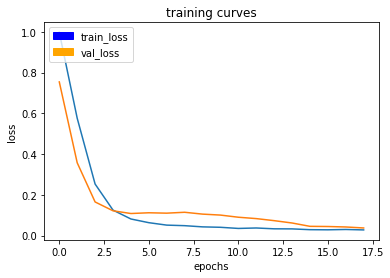

40/40 [==============================] - 41s - loss: 0.0278 - val_loss: 0.0373
Epoch 19/100
39/40 [============================>.] - ETA: 0s - loss: 0.0281

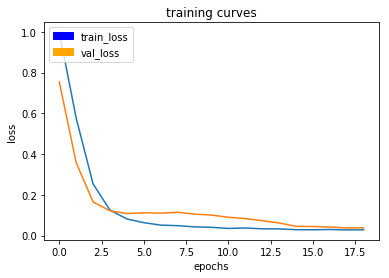

40/40 [==============================] - 42s - loss: 0.0281 - val_loss: 0.0381
Epoch 20/100
39/40 [============================>.] - ETA: 0s - loss: 0.0252

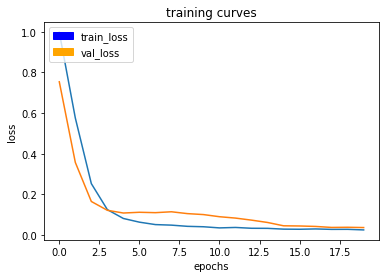

40/40 [==============================] - 41s - loss: 0.0251 - val_loss: 0.0367
Epoch 21/100
39/40 [============================>.] - ETA: 0s - loss: 0.0242

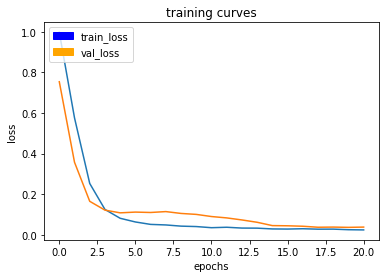

40/40 [==============================] - 42s - loss: 0.0241 - val_loss: 0.0380
Epoch 22/100
39/40 [============================>.] - ETA: 0s - loss: 0.0273

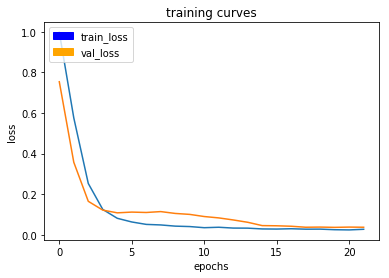

40/40 [==============================] - 42s - loss: 0.0273 - val_loss: 0.0373
Epoch 23/100
39/40 [============================>.] - ETA: 0s - loss: 0.0240

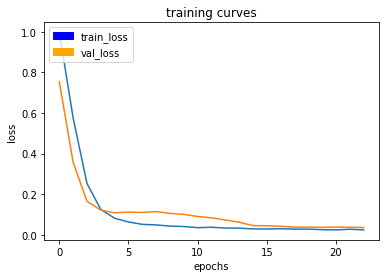

40/40 [==============================] - 42s - loss: 0.0240 - val_loss: 0.0355
Epoch 24/100
39/40 [============================>.] - ETA: 0s - loss: 0.0254

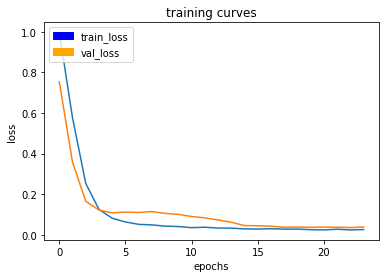

40/40 [==============================] - 41s - loss: 0.0258 - val_loss: 0.0383
Epoch 25/100
39/40 [============================>.] - ETA: 0s - loss: 0.0249

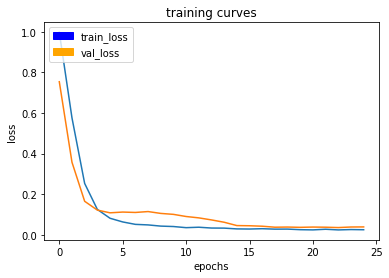

40/40 [==============================] - 42s - loss: 0.0249 - val_loss: 0.0388
Epoch 26/100
39/40 [============================>.] - ETA: 0s - loss: 0.0239

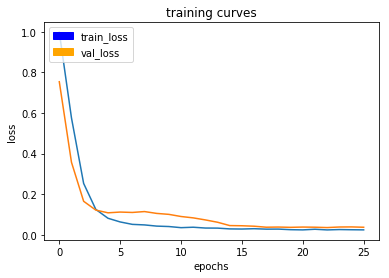

40/40 [==============================] - 42s - loss: 0.0242 - val_loss: 0.0371
Epoch 27/100
39/40 [============================>.] - ETA: 0s - loss: 0.0230

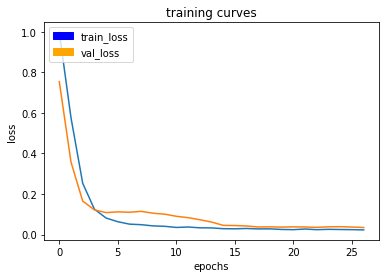

40/40 [==============================] - 42s - loss: 0.0229 - val_loss: 0.0347
Epoch 28/100
39/40 [============================>.] - ETA: 0s - loss: 0.0244

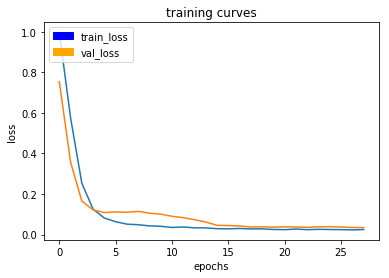

40/40 [==============================] - 42s - loss: 0.0248 - val_loss: 0.0344
Epoch 29/100
39/40 [============================>.] - ETA: 0s - loss: 0.0218

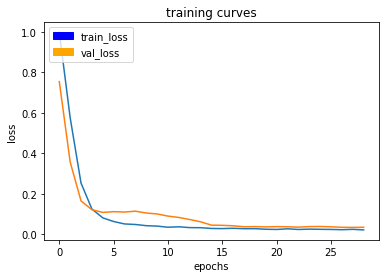

40/40 [==============================] - 42s - loss: 0.0218 - val_loss: 0.0348
Epoch 30/100
39/40 [============================>.] - ETA: 0s - loss: 0.0228

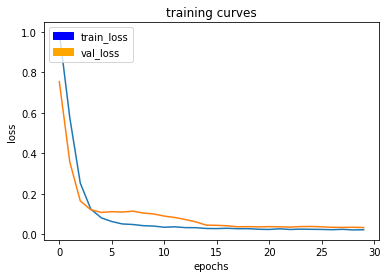

40/40 [==============================] - 42s - loss: 0.0228 - val_loss: 0.0335
Epoch 31/100
39/40 [============================>.] - ETA: 0s - loss: 0.0212

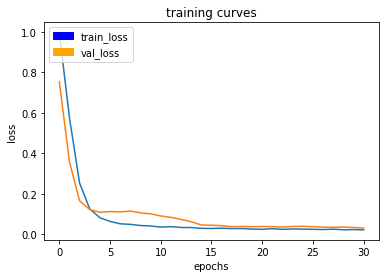

40/40 [==============================] - 42s - loss: 0.0211 - val_loss: 0.0304
Epoch 32/100
39/40 [============================>.] - ETA: 0s - loss: 0.0226

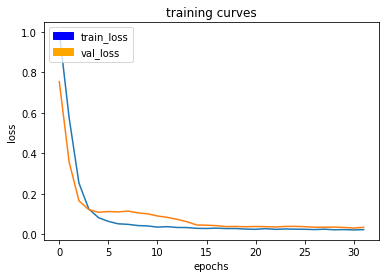

40/40 [==============================] - 42s - loss: 0.0225 - val_loss: 0.0340
Epoch 33/100
39/40 [============================>.] - ETA: 0s - loss: 0.0213

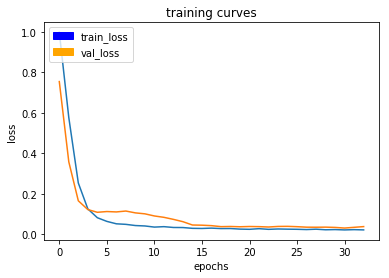

40/40 [==============================] - 41s - loss: 0.0212 - val_loss: 0.0376
Epoch 34/100
39/40 [============================>.] - ETA: 0s - loss: 0.0229

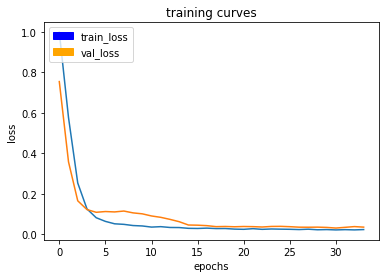

40/40 [==============================] - 42s - loss: 0.0229 - val_loss: 0.0349
Epoch 35/100
39/40 [============================>.] - ETA: 0s - loss: 0.0214

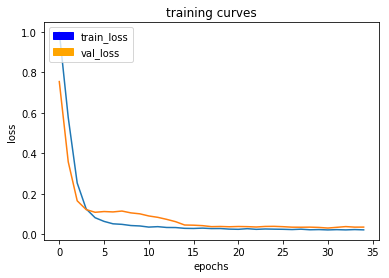

40/40 [==============================] - 42s - loss: 0.0213 - val_loss: 0.0350
Epoch 36/100
39/40 [============================>.] - ETA: 0s - loss: 0.0200

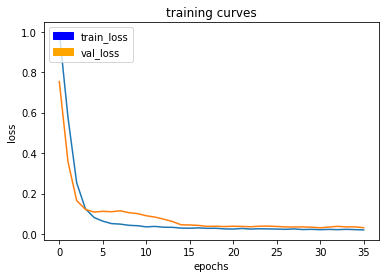

40/40 [==============================] - 42s - loss: 0.0200 - val_loss: 0.0310
Epoch 37/100
39/40 [============================>.] - ETA: 0s - loss: 0.0213

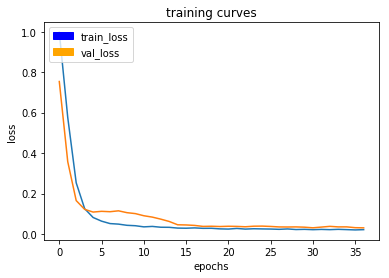

40/40 [==============================] - 42s - loss: 0.0213 - val_loss: 0.0302
Epoch 38/100
39/40 [============================>.] - ETA: 0s - loss: 0.0210

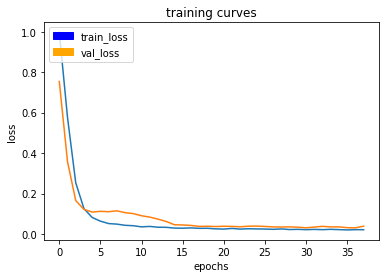

40/40 [==============================] - 42s - loss: 0.0210 - val_loss: 0.0384
Epoch 39/100
39/40 [============================>.] - ETA: 0s - loss: 0.0226

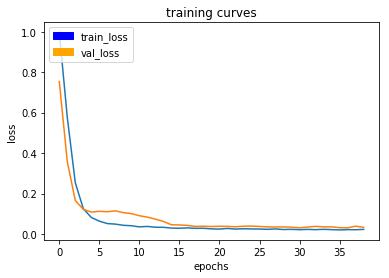

40/40 [==============================] - 42s - loss: 0.0224 - val_loss: 0.0326
Epoch 40/100
39/40 [============================>.] - ETA: 0s - loss: 0.0212

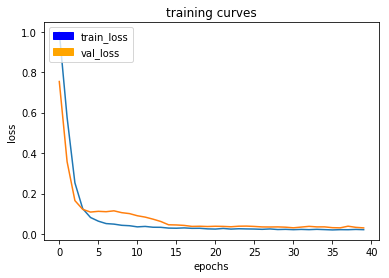

40/40 [==============================] - 41s - loss: 0.0211 - val_loss: 0.0300
Epoch 41/100
39/40 [============================>.] - ETA: 0s - loss: 0.0213

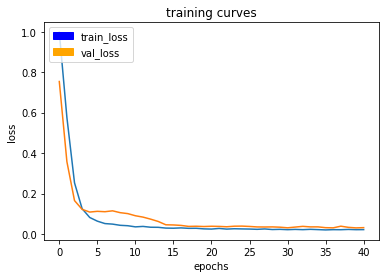

40/40 [==============================] - 42s - loss: 0.0214 - val_loss: 0.0312
Epoch 42/100
39/40 [============================>.] - ETA: 0s - loss: 0.0203

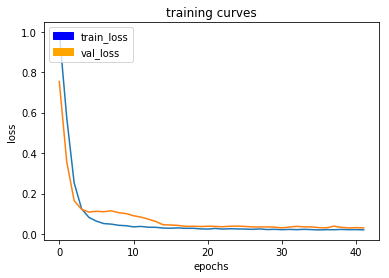

40/40 [==============================] - 42s - loss: 0.0202 - val_loss: 0.0299
Epoch 43/100
39/40 [============================>.] - ETA: 0s - loss: 0.0195

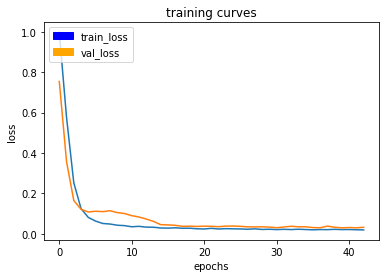

40/40 [==============================] - 42s - loss: 0.0195 - val_loss: 0.0324
Epoch 44/100
39/40 [============================>.] - ETA: 0s - loss: 0.0187

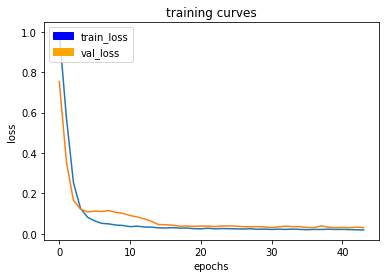

40/40 [==============================] - 42s - loss: 0.0187 - val_loss: 0.0302
Epoch 45/100
39/40 [============================>.] - ETA: 0s - loss: 0.0200

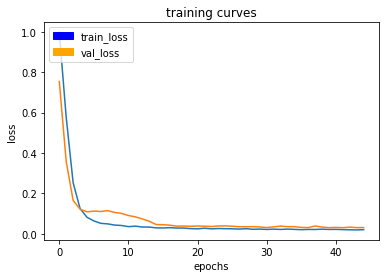

40/40 [==============================] - 43s - loss: 0.0201 - val_loss: 0.0303
Epoch 46/100
39/40 [============================>.] - ETA: 0s - loss: 0.0192

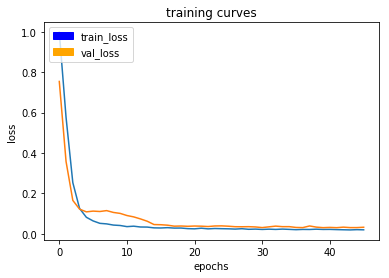

40/40 [==============================] - 42s - loss: 0.0192 - val_loss: 0.0320
Epoch 47/100
39/40 [============================>.] - ETA: 0s - loss: 0.0187

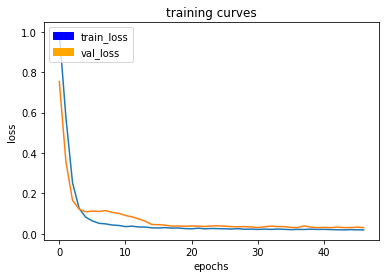

40/40 [==============================] - 42s - loss: 0.0186 - val_loss: 0.0301
Epoch 48/100
39/40 [============================>.] - ETA: 0s - loss: 0.0179

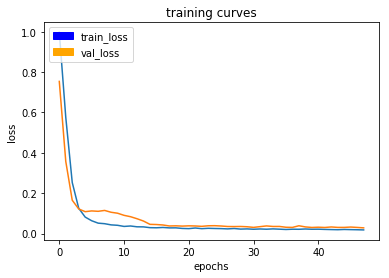

40/40 [==============================] - 42s - loss: 0.0178 - val_loss: 0.0280
Epoch 49/100
39/40 [============================>.] - ETA: 0s - loss: 0.0188

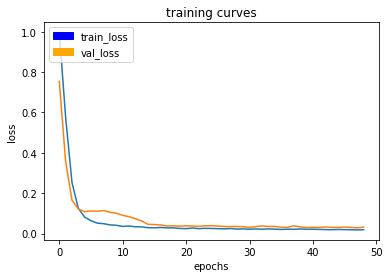

40/40 [==============================] - 42s - loss: 0.0188 - val_loss: 0.0318
Epoch 50/100
39/40 [============================>.] - ETA: 0s - loss: 0.0189

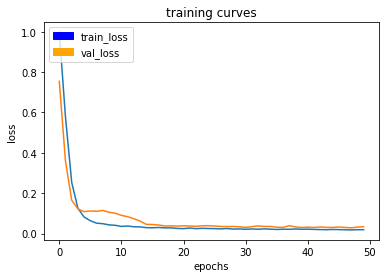

40/40 [==============================] - 41s - loss: 0.0188 - val_loss: 0.0338
Epoch 51/100
39/40 [============================>.] - ETA: 0s - loss: 0.0188

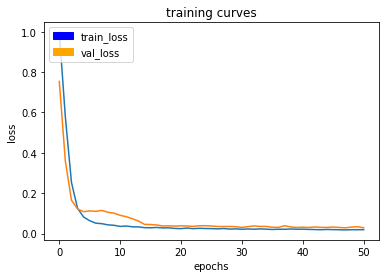

40/40 [==============================] - 42s - loss: 0.0189 - val_loss: 0.0282
Epoch 52/100
39/40 [============================>.] - ETA: 0s - loss: 0.0190

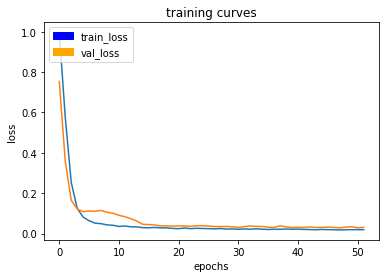

40/40 [==============================] - 42s - loss: 0.0189 - val_loss: 0.0306
Epoch 53/100
39/40 [============================>.] - ETA: 0s - loss: 0.0171

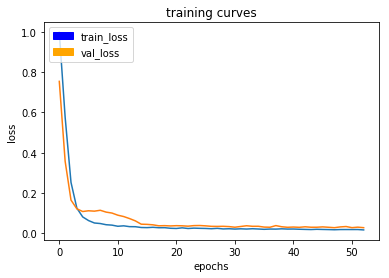

40/40 [==============================] - 42s - loss: 0.0170 - val_loss: 0.0280
Epoch 54/100
39/40 [============================>.] - ETA: 0s - loss: 0.0194

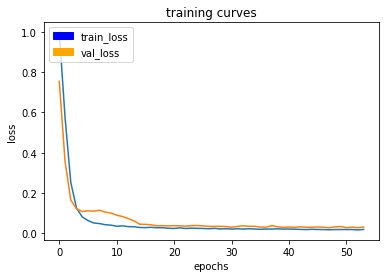

40/40 [==============================] - 42s - loss: 0.0194 - val_loss: 0.0312
Epoch 55/100
39/40 [============================>.] - ETA: 0s - loss: 0.0183

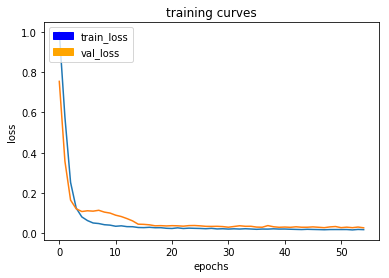

40/40 [==============================] - 42s - loss: 0.0182 - val_loss: 0.0274
Epoch 56/100
39/40 [============================>.] - ETA: 0s - loss: 0.0173

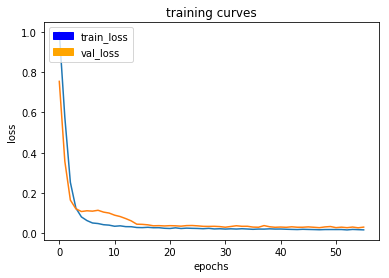

40/40 [==============================] - 42s - loss: 0.0173 - val_loss: 0.0308
Epoch 57/100
39/40 [============================>.] - ETA: 0s - loss: 0.0209

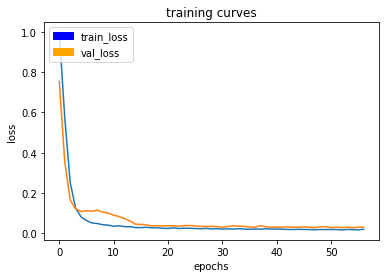

40/40 [==============================] - 42s - loss: 0.0208 - val_loss: 0.0306
Epoch 58/100
39/40 [============================>.] - ETA: 0s - loss: 0.0184

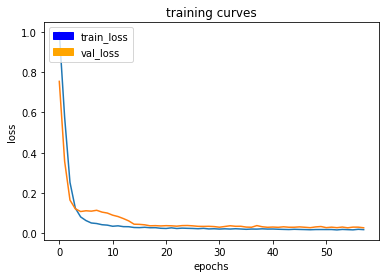

40/40 [==============================] - 42s - loss: 0.0183 - val_loss: 0.0276
Epoch 59/100
39/40 [============================>.] - ETA: 0s - loss: 0.0209

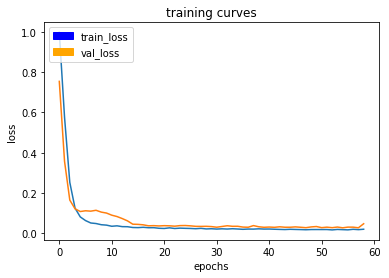

40/40 [==============================] - 42s - loss: 0.0209 - val_loss: 0.0476
Epoch 60/100
39/40 [============================>.] - ETA: 0s - loss: 0.0181

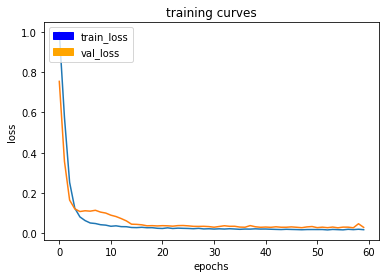

40/40 [==============================] - 42s - loss: 0.0181 - val_loss: 0.0295
Epoch 61/100
39/40 [============================>.] - ETA: 0s - loss: 0.0196

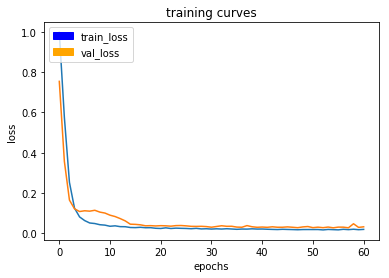

40/40 [==============================] - 42s - loss: 0.0194 - val_loss: 0.0324
Epoch 62/100
39/40 [============================>.] - ETA: 0s - loss: 0.0165

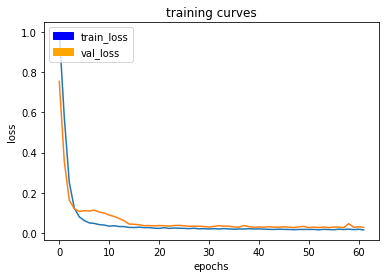

40/40 [==============================] - 42s - loss: 0.0165 - val_loss: 0.0291
Epoch 63/100
39/40 [============================>.] - ETA: 0s - loss: 0.0181

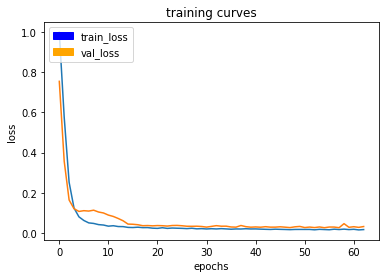

40/40 [==============================] - 42s - loss: 0.0181 - val_loss: 0.0332
Epoch 64/100
39/40 [============================>.] - ETA: 0s - loss: 0.0168

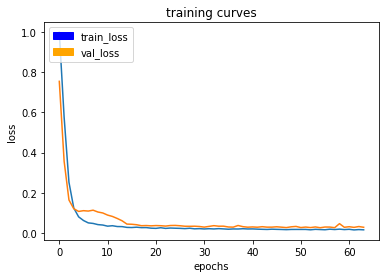

40/40 [==============================] - 42s - loss: 0.0169 - val_loss: 0.0295
Epoch 65/100
39/40 [============================>.] - ETA: 0s - loss: 0.0160

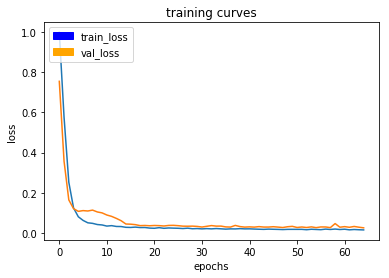

40/40 [==============================] - 42s - loss: 0.0161 - val_loss: 0.0264
Epoch 66/100
39/40 [============================>.] - ETA: 0s - loss: 0.0176

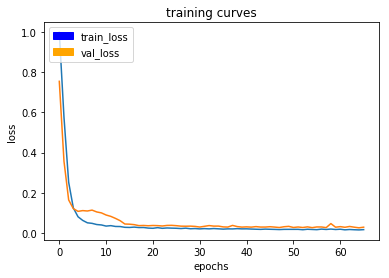

40/40 [==============================] - 41s - loss: 0.0175 - val_loss: 0.0296
Epoch 67/100
39/40 [============================>.] - ETA: 0s - loss: 0.0164

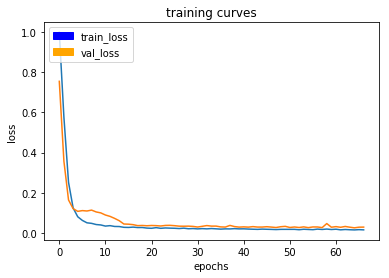

40/40 [==============================] - 42s - loss: 0.0163 - val_loss: 0.0299
Epoch 68/100
39/40 [============================>.] - ETA: 0s - loss: 0.0183

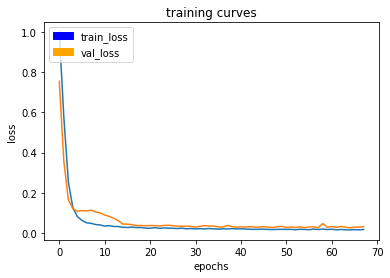

40/40 [==============================] - 42s - loss: 0.0182 - val_loss: 0.0324
Epoch 69/100
39/40 [============================>.] - ETA: 0s - loss: 0.0174

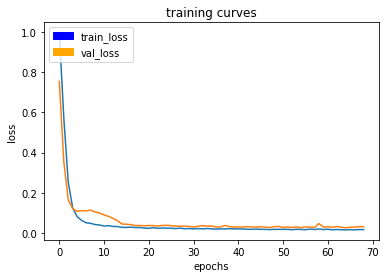

40/40 [==============================] - 42s - loss: 0.0173 - val_loss: 0.0315
Epoch 70/100
39/40 [============================>.] - ETA: 0s - loss: 0.0185

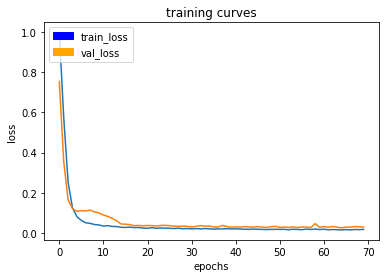

40/40 [==============================] - 42s - loss: 0.0184 - val_loss: 0.0298
Epoch 71/100
39/40 [============================>.] - ETA: 0s - loss: 0.0160

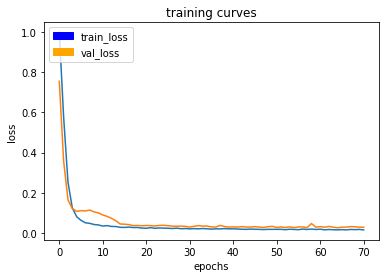

40/40 [==============================] - 42s - loss: 0.0160 - val_loss: 0.0292
Epoch 72/100
39/40 [============================>.] - ETA: 0s - loss: 0.0161

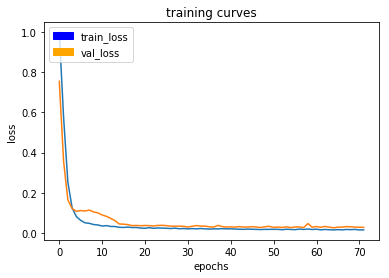

40/40 [==============================] - 42s - loss: 0.0160 - val_loss: 0.0286
Epoch 73/100
39/40 [============================>.] - ETA: 0s - loss: 0.0155

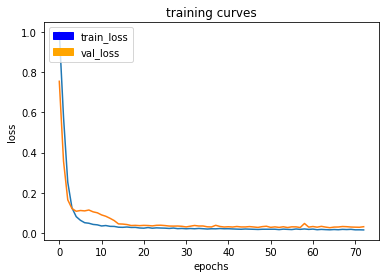

40/40 [==============================] - 42s - loss: 0.0155 - val_loss: 0.0314
Epoch 74/100
39/40 [============================>.] - ETA: 0s - loss: 0.0170

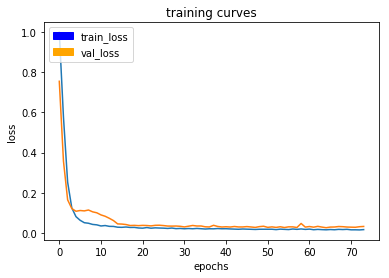

40/40 [==============================] - 41s - loss: 0.0169 - val_loss: 0.0327
Epoch 75/100
39/40 [============================>.] - ETA: 0s - loss: 0.0155

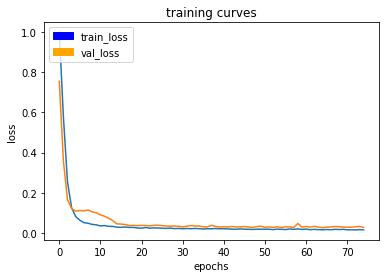

40/40 [==============================] - 42s - loss: 0.0154 - val_loss: 0.0280
Epoch 76/100
39/40 [============================>.] - ETA: 0s - loss: 0.0166

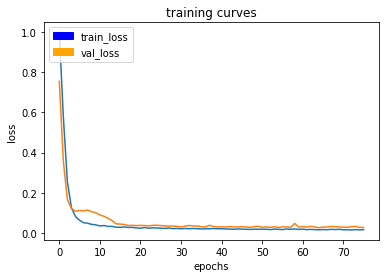

40/40 [==============================] - 42s - loss: 0.0166 - val_loss: 0.0279
Epoch 77/100
39/40 [============================>.] - ETA: 0s - loss: 0.0168

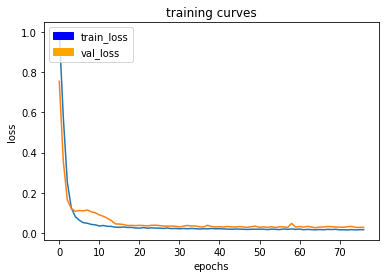

40/40 [==============================] - 42s - loss: 0.0167 - val_loss: 0.0283
Epoch 78/100
39/40 [============================>.] - ETA: 0s - loss: 0.0153

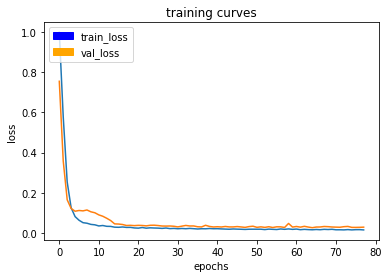

40/40 [==============================] - 42s - loss: 0.0154 - val_loss: 0.0290
Epoch 79/100
39/40 [============================>.] - ETA: 0s - loss: 0.0146

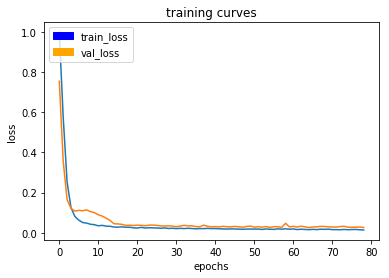

40/40 [==============================] - 42s - loss: 0.0146 - val_loss: 0.0269
Epoch 80/100
39/40 [============================>.] - ETA: 0s - loss: 0.0154

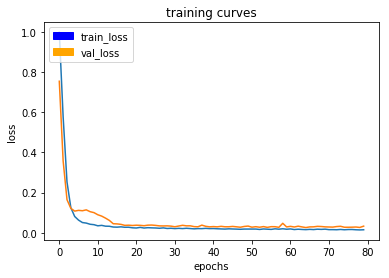

40/40 [==============================] - 42s - loss: 0.0154 - val_loss: 0.0333
Epoch 81/100
39/40 [============================>.] - ETA: 0s - loss: 0.0186

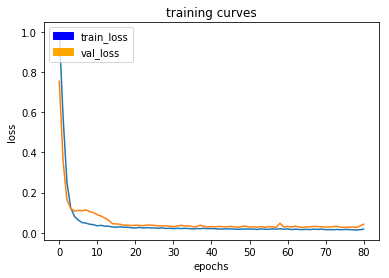

40/40 [==============================] - 42s - loss: 0.0186 - val_loss: 0.0433
Epoch 82/100
39/40 [============================>.] - ETA: 0s - loss: 0.0165

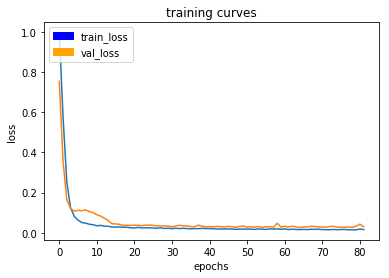

40/40 [==============================] - 42s - loss: 0.0166 - val_loss: 0.0303
Epoch 83/100
39/40 [============================>.] - ETA: 0s - loss: 0.0169

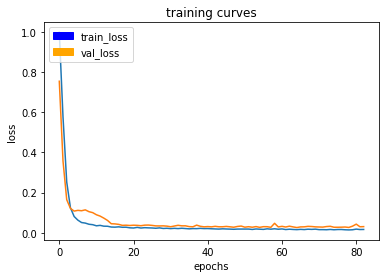

40/40 [==============================] - 41s - loss: 0.0169 - val_loss: 0.0310
Epoch 84/100
39/40 [============================>.] - ETA: 0s - loss: 0.0180

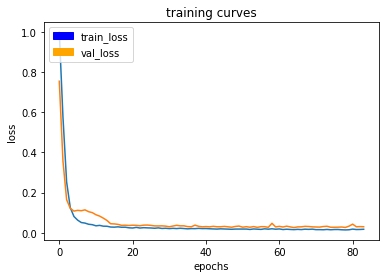

40/40 [==============================] - 42s - loss: 0.0179 - val_loss: 0.0304
Epoch 85/100
39/40 [============================>.] - ETA: 0s - loss: 0.0162

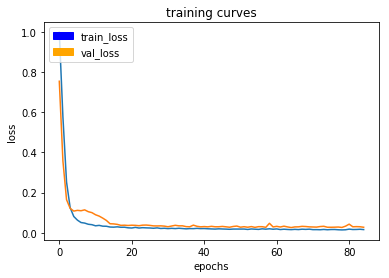

40/40 [==============================] - 42s - loss: 0.0162 - val_loss: 0.0279
Epoch 86/100
39/40 [============================>.] - ETA: 0s - loss: 0.0153

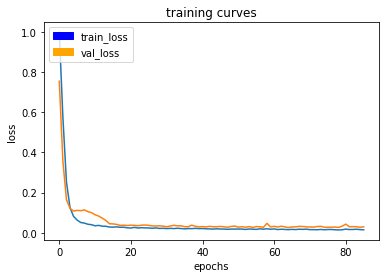

40/40 [==============================] - 43s - loss: 0.0152 - val_loss: 0.0301
Epoch 87/100
39/40 [============================>.] - ETA: 0s - loss: 0.0176

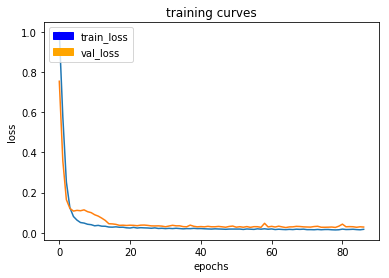

40/40 [==============================] - 42s - loss: 0.0176 - val_loss: 0.0289
Epoch 88/100
39/40 [============================>.] - ETA: 0s - loss: 0.0150

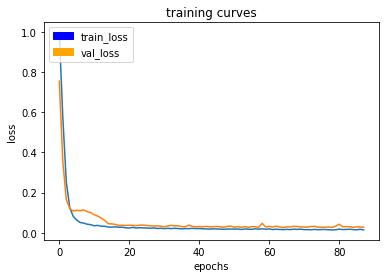

40/40 [==============================] - 42s - loss: 0.0150 - val_loss: 0.0280
Epoch 89/100
39/40 [============================>.] - ETA: 0s - loss: 0.0155

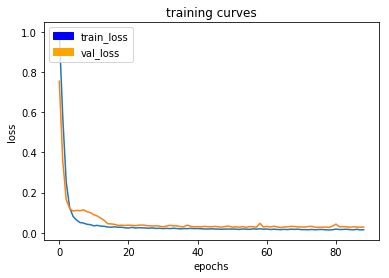

40/40 [==============================] - 42s - loss: 0.0156 - val_loss: 0.0293
Epoch 90/100
39/40 [============================>.] - ETA: 0s - loss: 0.0156

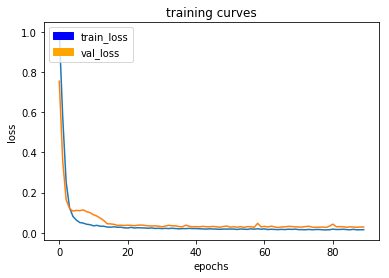

40/40 [==============================] - 42s - loss: 0.0157 - val_loss: 0.0291
Epoch 91/100
39/40 [============================>.] - ETA: 0s - loss: 0.0145

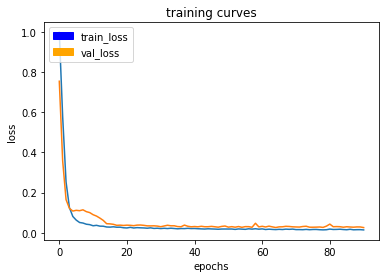

40/40 [==============================] - 42s - loss: 0.0144 - val_loss: 0.0261
Epoch 92/100
39/40 [============================>.] - ETA: 0s - loss: 0.0147

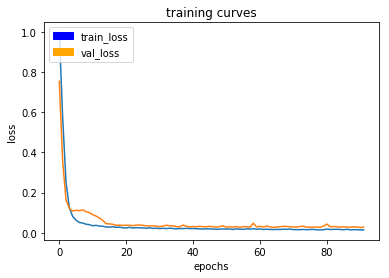

40/40 [==============================] - 42s - loss: 0.0147 - val_loss: 0.0288
Epoch 93/100
39/40 [============================>.] - ETA: 0s - loss: 0.0139

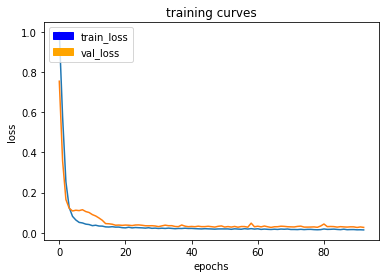

40/40 [==============================] - 42s - loss: 0.0139 - val_loss: 0.0265
Epoch 94/100
39/40 [============================>.] - ETA: 0s - loss: 0.0167

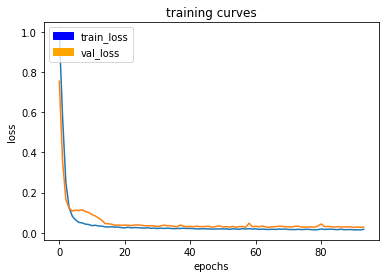

40/40 [==============================] - 42s - loss: 0.0167 - val_loss: 0.0280
Epoch 95/100
39/40 [============================>.] - ETA: 0s - loss: 0.0144

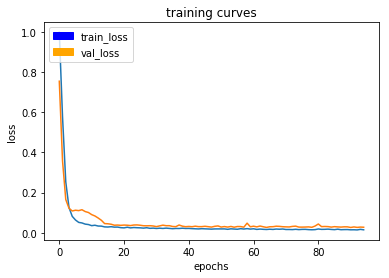

40/40 [==============================] - 42s - loss: 0.0145 - val_loss: 0.0273
Epoch 96/100
39/40 [============================>.] - ETA: 0s - loss: 0.0143

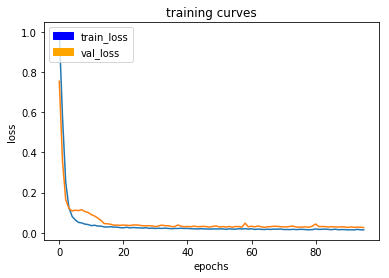

40/40 [==============================] - 42s - loss: 0.0143 - val_loss: 0.0255
Epoch 97/100
39/40 [============================>.] - ETA: 0s - loss: 0.0137

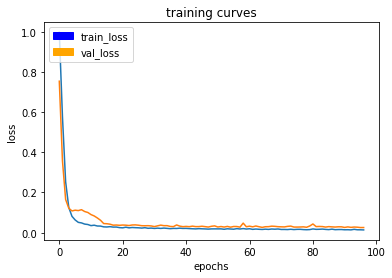

40/40 [==============================] - 42s - loss: 0.0137 - val_loss: 0.0256
Epoch 98/100
39/40 [============================>.] - ETA: 0s - loss: 0.0156

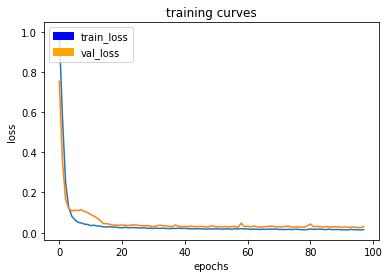

40/40 [==============================] - 42s - loss: 0.0155 - val_loss: 0.0302
Epoch 99/100
39/40 [============================>.] - ETA: 0s - loss: 0.0154

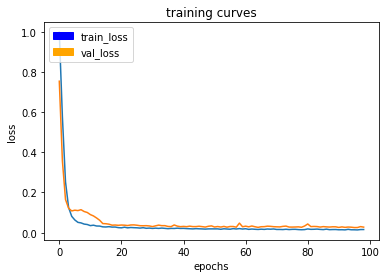

40/40 [==============================] - 42s - loss: 0.0157 - val_loss: 0.0276
Epoch 100/100
39/40 [============================>.] - ETA: 0s - loss: 0.0143

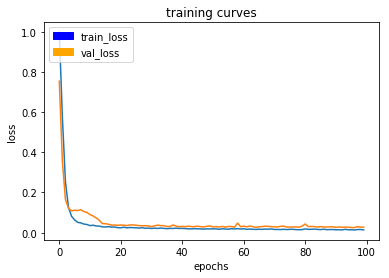

40/40 [==============================] - 41s - loss: 0.0143 - val_loss: 0.0277
Wall time: 1h 10min 46s


In [11]:
%%time
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# # Define the Keras model and compile it for training
# model = models.Model(inputs=inputs, outputs=output_layer)
#
# model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [12]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [ ]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [13]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

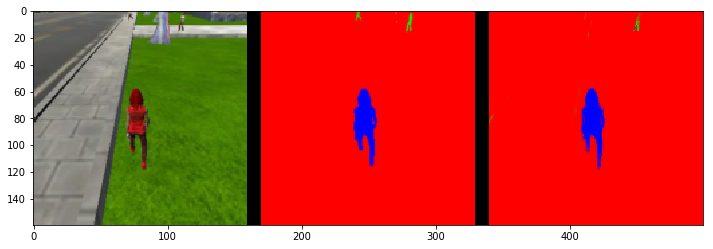

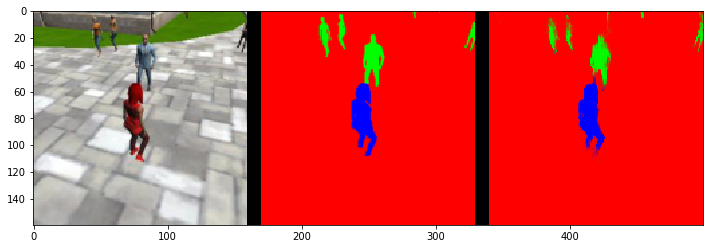

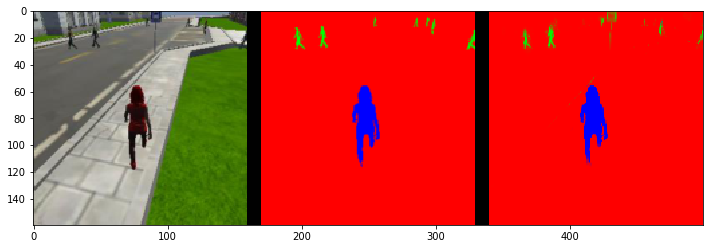

In [14]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

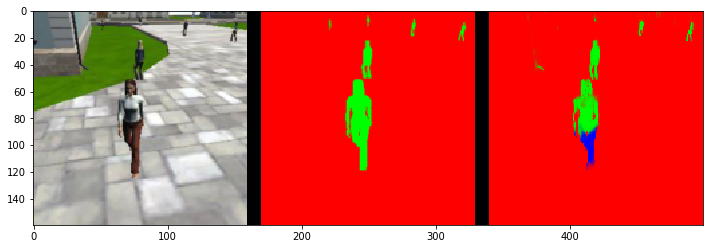

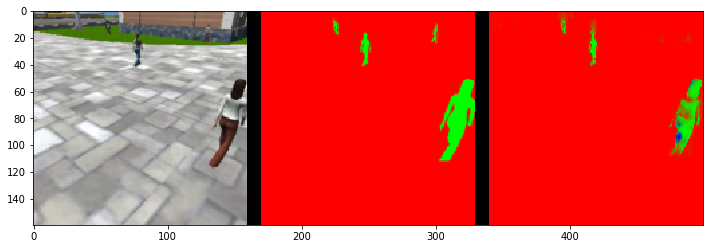

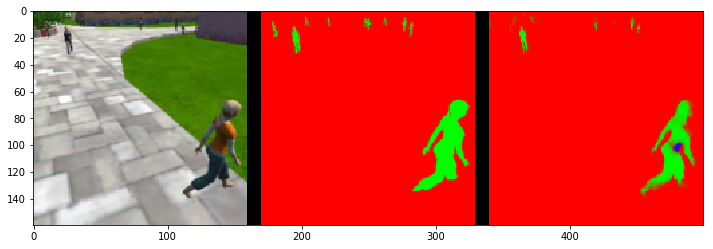

In [35]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

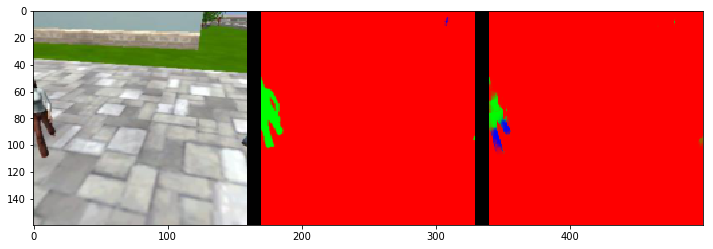

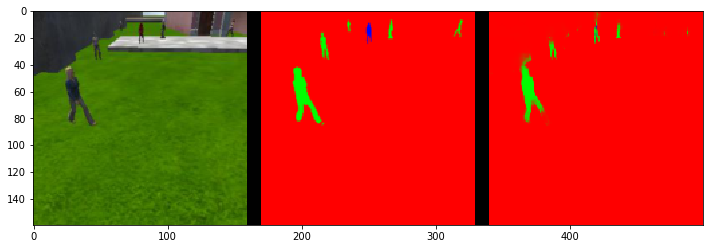

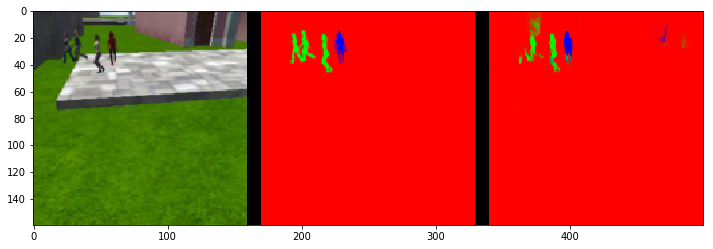

In [39]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [17]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9950652339377402
average intersection over union for other people is 0.29953877833348647
average intersection over union for the hero is 0.9044330816408218
number true positives: 539, number false positives: 0, number false negatives: 0


In [18]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9849939027545719
average intersection over union for other people is 0.6601820897669134
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 113, number false negatives: 0


In [19]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9961043212822083
average intersection over union for other people is 0.38336871859983407
average intersection over union for the hero is 0.20113339510658926
number true positives: 132, number false positives: 3, number false negatives: 169


In [20]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7018828451882845


In [21]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.552783238374


In [22]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.387989072122
